In [1]:
%matplotlib widget
from __future__ import annotations
import copy
from typing import Callable, Optional, Tuple
from dataclasses import dataclass
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Bayesian non-parametric regression
Alex Gorodetsky October 2020, February 2024

In this notebook we look at whats called a *nonparametric* alternative to the *parametric* regression covered previously.This approach is typically called "Gaussian process regression", although the parametric form is strictly/technically also Gaussian process regression.

Suppose that we want to predict a function at a point $f(x^*)$. However we have data at other points as in the standard regression problem $(x^{(i)}, y^{(i)})$ Can we directly infer $$f(x^{*}) \mid \text{data}$$
The answer is yes! We just need a prior on the space of functions instead of the space of parameters. 


<font color='red'>
Note: some simple re-arranging of the parametric approach allow us to completly bipass any inference on the parameters and directly update from prior-predictive to posterior-predictive. In other words, what we are presenting in this notebook is *strictly equivalent* to the parametric approach presented previously. We will show how to map from one to the other and their relative advantages later.
</font>

## Gaussian process regression
For this we use a *Gaussian Process Prior*. Recall that a Gaussian Process (GP) describes a distribution over functions. 

**Definition: (Gaussian Process)**
  Let $(\Omega, \mathcal{F}, P)$ be a probability space. A *Gaussian process* is a distribution over functions $\left\{f_{\omega}: \omega \in \Omega, f_{\omega}:\mathcal{X} \to \mathbb{R} \right\}$ such that for any collection of $n$ inputs $\bar{x} = \left[x^{(i)}, \ldots,x^{(n)}\right]$, where $x^{(i)} \in \mathcal{X}$, the collection of $n$ random variables $f(\bar{x}) = [f(x^{(1)}), \ldots, f(x^{(n)})]$ has a multivariate Gaussian distribution.
  
A Gaussian Process can be completely specified by a mean and covariance function. Let $m(x)$ denote the expectation of the Gaussian process at any point $x \in \mathcal{X}$ and let $k(x, x^{\prime})$ denote the covariance between the function values at any two points $x,x^{\prime} \in \mathcal{X}$, i.e., 

\begin{align}
  m(x) &\equiv \mathbb{E}[f(x)],\\
  k(x, x^{\prime}) &\equiv \mathbb{C}\text{ov}[f(x), f(x^{\prime})] \equiv \mathbb{E}[(f(x) - m(x))(f(x^{\prime}) -
  m(x^{\prime}))],
\end{align}

The notation for a Gaussian Process is:

\begin{equation}
  f(x) \sim \mathcal{GP}(m(x), k(x, x^{\prime})). \label{eq:GP}
\end{equation}

The posterior predictions are then distributed according to $f(x) \mid data \sim \mathcal{N}(m_p(x), k_p(x, x^{\prime}))$ where

\begin{align}
m_p(x) &= m(x) + k(x, \bar{x})\left(k(\bar{x}, \bar{x}) + \sigma^2I\right)^{-1}(\bar{y} - m(\bar{x})) \\
k_p(x, x^{\prime}) &= k(x, x^{\prime}) - k(x, \bar{x})\left(k(\bar{x}, \bar{x}) + \sigma^2I\right)^{-1}k(\bar{x}, x^{\prime})
\end{align}

## Some covariance kernels

The covariance kernels describe the covariance between the function values at two inputs. There are many options for this covariance (link). Here we show three examples. (Note for your projects you will have to make 2D kernels out of these 1D kernels)


The squared exponential $k(x, x^{\prime}) = \tau \exp(-\frac{1}{2} (x - x^{\prime})^2 / l^2)$

In two dimensions, one can multiply the covariance kernels of one dimension together

\begin{equation}
k( (x_1, x_2), (x_1^{\prime}, x_2^{\prime})) = \tau_1 \exp(-\frac{1}{2} (x_1 - x_1^{\prime})^2 / l_1^2) \tau_2 \exp(-\frac{1}{2} (x_2 - x_2^{\prime})^2 / l_2^2)
\end{equation}

In [3]:
def sqexp(x: np.ndarray, xp: float, tau: float=1, l: float=0.5) -> np.ndarray:
    """Squared exponential kernel (1 dimensional).

    Args:
        x: (N), array of multiple inputs
        xp: float

    Returns:
        cov (N,) -- Covariance between each input at *x* and the function values at *x*
    """
    cov = tau**2 * np.exp(-1/2 * (x - xp)**2 / l**2)
    return cov

def periodic(x: np.ndarray, xp: float, tau: float=1, l: float=1.0, p: float=0.4) -> np.ndarray:
    """Periodic kernel."""
    return tau**2 * np.exp ( -2 * np.sin(np.pi * np.abs(x - xp) / p )**2 / l**2)

def poly(x: np.ndarray, xp: float, c: float=1, d: int=3):
    """Polynomial kernel."""
    return (x * xp + c)**d

kernel_options = {"Sq.Exp":sqexp, "Periodic":periodic, "Poly":poly}


Lets also write some code to build a covariance matrix from kernel and a set of input points

In [4]:
def build_covariance(x: np.ndarray, xp: np.ndarray, kern: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> np.ndarray:
    """Build a covariance matrix.

    Args:
        x: (N) array of inputs
        xp: (M) array of inptus
        kern: a function mapping inputs to covariance

    Outputs:
        cov: (N, M) covariance matrix
    """
    out = np.zeros((x.shape[0], xp.shape[0]))
    for jj in range(xp.shape[0]):
        out[:, jj] = kern(x, xp[jj])
    return out

### Visualizing functions from a gaussian process

We can now look at the distributions of functions under different covariance kernels

In [5]:
def sample_functions(x: np.ndarray, nsamples: int,
                     mean_func: Callable[[np.ndarray], np.ndarray],
                     kern: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> np.ndarray:
    """Generate samples of functions from a Gaussian process.

    Args:
        x: (N,) locations at which to obtain samples
        nsamples: integer, number of functions to sample
        mean_func: function to evaluate the prior mean at each location
        kern: covariance kernel function

    Returns:
        out: (N, nsamples) : array of functions, each column is a function
    """
    cov = build_covariance(x, x, kern)
    # print("cov = ", cov)
    u, s, v = np.linalg.svd(cov)
    sqrtcov = np.dot(u, np.sqrt(np.diag(s)))
    out = np.tile(mean_func(x)[:, np.newaxis], (1, nsamples)) + \
                  np.dot(sqrtcov, np.random.randn(x.shape[0], nsamples))
    return out

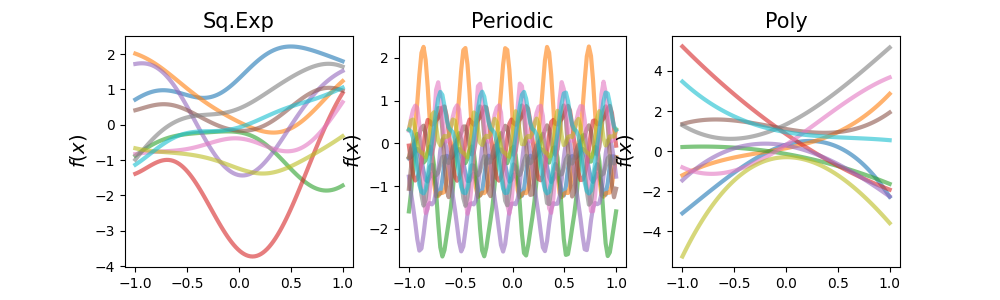

In [6]:
plt.close(1)
fig, axs = plt.subplots(1, len(kernel_options),  figsize=(10,3), num=1)
xspace = np.linspace(-1, 1, 100)
mean_func = lambda x: np.zeros((x.shape[0]))
# mean_func = lambda x: 10*x**2
for ii, (kname, kfunc) in enumerate(kernel_options.items()):
    #print(kname)
    funcs = sample_functions(xspace, 10, mean_func, kfunc)
    for jj in range(funcs.shape[1]):
        axs[ii].plot(xspace, funcs[:, jj], lw=3, alpha=0.6)
    axs[ii].set_title(kname, fontsize=15)
    axs[ii].set_xlabel(r'$x$', fontsize=14)
    axs[ii].set_ylabel(r'$f(x)$', fontsize=14)
plt.show()

Products of kernels and sums of kernels (composite kernels) are also valid covariance kernels

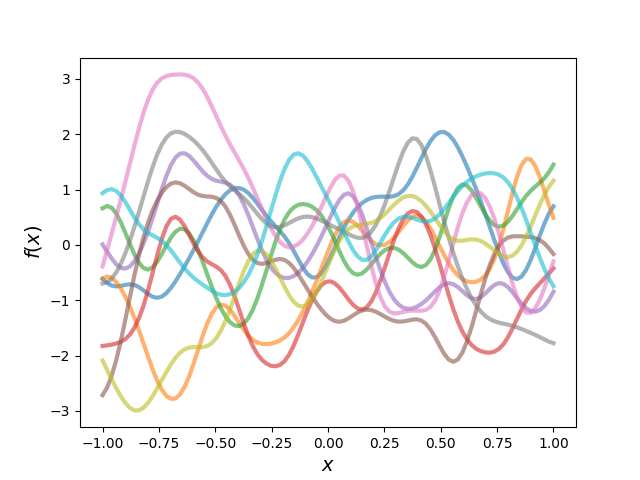

In [7]:
def composite(x: np.ndarray, xp: float) -> np.ndarray:
    return sqexp(x,xp) * periodic(x,xp, p=1)
plt.close(2)
plt.figure(2)
funcs = sample_functions(xspace, 10, mean_func, composite)
for jj in range(funcs.shape[1]):
    plt.plot(xspace, funcs[:, jj], lw=3, alpha=0.6)
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$f(x)$', fontsize=14)
plt.show()

## Nonparametric GP regression

Finally, we code up the nonparametric GP regression algorithm

In [8]:
def gpr(xtrain: np.ndarray,
        ytrain: np.ndarray,
        xpred: np.ndarray,
        noise_var: np.ndarray,
        mean_func: Callable[[np.ndarray], np.ndarray],
        kernel: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
    """Gaussian process regression Algorithm.

    Inputs:

        xtrain: (N, ) training inputs
        ytrain: (N, ) training outputs
        xpred:  (M, ) locations at which to make predictions
        noise_var: (N, ) noise at every training output
        mean_func: function to compute the prior mean
        kernel: covariance kernel

    Returns:
        pred_mean: (M, ) predicted mean at prediction points
        pred_cov: (M, M) predicted covariance at the prediction points
    """
    cov = build_covariance(xtrain, xtrain, kernel)
    #u, s, v = np.linalg.svd(cov)
    #sqrtcov = np.dot(u, np.sqrt(np.diag(s)))

    # pseudoinverse is better conditioned
    invcov = np.linalg.pinv(cov + np.diag(noise_var))

    vec_pred = build_covariance(xpred, xtrain, kernel)
    pred_mean = mean_func(xpred) + np.dot(vec_pred, np.dot(invcov, ytrain - mean_func(xtrain)))

    cov_predict_pre = build_covariance(xpred, xpred, kernel)
    cov_predict_up = np.dot(vec_pred, np.dot(invcov, vec_pred.T))
    pred_cov = cov_predict_pre - cov_predict_up

    return pred_mean, pred_cov

We can also add the following helper function for visualization

In [9]:
def plot_function_gp(axis, pred_mean, predict_cov, xdata, ydata, xpred, ytrue, title, label):
    axis.plot(xdata, ydata, 'o', ms=10, label='data')
    axis.plot(xpred, ytrue, '-', lw=3, color='black', label='true function')
    axis.plot(xpred, pred_mean, 'r--', lw=3, label=label)
    pred_fstd = np.sqrt(np.diag(predict_cov))
    axis.fill_between(xpred, pred_mean - 2*pred_fstd, pred_mean+2*pred_fstd, lw=3, label=r'2$\sigma$', color='red', alpha=0.2)
    axis.legend()
    axis.set_title(title, fontsize=14)

## Demo

Lets now set up a demo and look at some predictions

In [10]:
def true_function(x):
    #return np.exp(-x**2 / 0.1)*np.sin(10*x) #- x**3
    return 5*x**5*np.sin(20*x) + 0.2*x**6 - x - 0.5 #+ 10
    #return np.sin(9.5 * np.pi * x) + 10.0
xspace = np.linspace(-1,1,300)
num_data = 20
noise_cov = 1e-3
#noise_cov = 1e-2


#XDATA = np.random.rand(NUM_DATA)*2.0 - 1.0 # randomly spaced data
xdata = np.linspace(-1, 1, num_data) # linearly space data
ydata = true_function(xdata) + np.random.randn(num_data) * np.sqrt(noise_cov)
ytrue = true_function(xspace)

In [11]:
def gp_regression_demo(fignum, mean_func, kernel, xdata, ydata, xtrue, ytrue, noise_cov=1e-1):

    prior_mean = mean_func(xtrue)
    prior_cov = build_covariance(xtrue, xtrue, kernel)
    fig, axis = plt.subplots(1, 2, figsize=(10, 5), num=fignum)
    plot_function_gp(axis[0], prior_mean, prior_cov, xdata, ydata, xtrue, ytrue, "Prior", "Prior mean")

    # perform inference
    mean_predict, cov_predict = gpr(xdata, ydata, xtrue, noise_cov * np.ones((xdata.shape[0])), mean_func, kernel)
    plot_function_gp(axis[1], mean_predict, cov_predict, xdata, ydata, xtrue, ytrue, "Posterior", "Posterior mean")
    plt.tight_layout()
    plt.show()

# always use zero mean
meanf = lambda x: np.zeros((x.shape[0]))
# meanf = lambda x: 10*x**2
# meanf = lambda x: true_function(x)

In [12]:
# Squared Exponential Kernel
@interact_manual(tau=(0.5,2,0.2), log_width=(-4, 1, 0.1), log_noise_learn=(-10,0,1))
def sqexp_infer(tau=1, log_width=-1, log_noise_learn=np.log10(noise_cov)):
    kernel_tot = kernel_options['Sq.Exp']
    def kernel(x, xp):
        return kernel_tot(x, xp, tau=tau, l=10**log_width)
    plt.close(3)
    gp_regression_demo(3, meanf, kernel, xdata, ydata, xspace, ytrue, noise_cov=10**log_noise_learn)

interactive(children=(FloatSlider(value=1.0, description='tau', max=2.0, min=0.5, step=0.2), FloatSlider(value…

In [13]:
# Periodic Exponential
@interact_manual(tau=(0.5,2,0.2), log_width=(-4, 1, 0.5), p=(0.1,1,0.1), log_noise_learn=(-10,0,1))
def period_infer(tau=1, log_width=0, p=1, log_noise_learn=np.log10(noise_cov)):
    kernel_tot = kernel_options['Periodic']
    def kernel(x, xp):
        return kernel_tot(x, xp, tau=tau, l=10**log_width, p=p)
    plt.close(4)
    gp_regression_demo(4, meanf, kernel, xdata, ydata, xspace, ytrue, noise_cov=10**log_noise_learn)

interactive(children=(FloatSlider(value=1.0, description='tau', max=2.0, min=0.5, step=0.2), FloatSlider(value…

In [14]:
@interact_manual(log_width_sq=(-4, 1, 0.5), p=(0.1,1.8,0.1), log_width_per=(-4, 1, 0.5), log_noise_learn=(-10,0,1))
def sqexp_infer(tau=1, log_width_sq=0, log_width_per=0, p=1, log_noise_learn=np.log10(noise_cov)):
    kernel_tot_sq = kernel_options['Sq.Exp']
    kernel_tot_per = kernel_options['Periodic']
    def kernel(x, xp):
        k1 = kernel_tot_sq(x, xp, tau=tau, l=10**log_width_sq)
        k2 = kernel_tot_per(x, xp, tau=tau, l=10**log_width_per, p=p)
        return k1 * k2
    plt.close(5)
    gp_regression_demo(5, meanf, kernel, xdata, ydata, xspace, ytrue, noise_cov=10**log_noise_learn)

interactive(children=(IntSlider(value=1, description='tau', max=3, min=-1), FloatSlider(value=0.0, description…